<a href="https://colab.research.google.com/github/NDCHIRO/Cartoonizer/blob/master/cycleGAN_human_to_cartoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -qq git+https://www.github.com/keras-team/keras-contrib.git

In [3]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-th67yo59
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-th67yo59
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=3f07faf9e94dcfeea46c514c117ea6ac25307c282cfd5f4e84c00a42a5150170
  Stored in directory: /tmp/pip-ephem-wheel-cache-lr9xckjv/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [4]:
!pip install transformers==2.11.0

     |████████████████████████████████| 675kB 14.4MB/s 
     |████████████████████████████████| 1.2MB 22.9MB/s 
     |████████████████████████████████| 901kB 58.7MB/s 
     |████████████████████████████████| 5.6MB 50.5MB/s 


In [5]:
import numpy as np
from tensorflow.keras import initializers
from numpy import load
import matplotlib.pyplot as plt
from os import listdir
from numpy import vstack
from numpy import savez_compressed
from numpy import asarray
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Flatten, Conv2D,Conv2DTranspose
from keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Activation, Dense
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.models import Model
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model
#for saving .h5 files
import h5py

In [6]:
#!unrar x "/content/drive/MyDrive/graduation project/datasets/training and testing on data.rar" "/content/drive/MyDrive/graduation project/datasets/"

# loading datasets of cartoon and real human faces

In [7]:
import cv2
#load images
def load_images(path,size=(256,256)):
    data_list=list()
    for filename in listdir(path):
      #load images onlt not the excel files too 
      if filename.endswith(('jpg','png','jpeg','bmp')):
          pixels=load_img(path+filename,target_size=size)
          pixels=img_to_array(pixels)
          data_list.append(pixels)
    return asarray(data_list)

path ='/content/drive/MyDrive/graduation_project/datasets/'
#load Cartoon dataset
dataCartoonTrain = load_images(path+'trainCartoon/')
dataCartoonTest  = load_images(path+'testCartoon/')
dataCartoon =vstack((dataCartoonTrain,dataCartoonTest))
print('loaded Cartoon data:', dataCartoon.shape)

#load real world faces dataset
datarealHumanTrain = load_images(path+'trainRealHuman/')
datarealHumanTest  = load_images(path+'testRealHuman/')
dataRealHuman =vstack((datarealHumanTrain,datarealHumanTest))
print('loaded Real Human data:', dataRealHuman.shape)

#save as compressed numpy array
fileName = '/content/drive/MyDrive/graduation_project/datasets/cebrity2Cartoon.npz'
savez_compressed(fileName,dataCartoon,dataRealHuman)
print('saved dataset: ', fileName)

loaded Cartoon data: (25, 256, 256, 3)
loaded Real Human data: (36, 256, 256, 3)
saved dataset:  /content/drive/MyDrive/graduation_project/datasets/cebrity2Cartoon.npz


Resizing images to 256 * 256 *3
## Plotting images of Celebrity and Cartoon

loaded:  (25, 256, 256, 3) (36, 256, 256, 3)


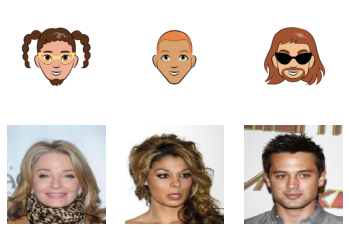

In [8]:
#load the compressed dataset array
data = np.load('/content/drive/MyDrive/graduation_project/datasets/cebrity2Cartoon.npz')
dataCartoon,dataRealHuman=data['arr_0'], data['arr_1']
print('loaded: ', dataCartoon.shape, dataRealHuman.shape)

#plot source images
n_samples = 3 #display 2 images of humans and cartoon
for i in range(n_samples):
  plt.subplot(2,n_samples, 1+i)
  plt.axis('off')
  plt.imshow(dataCartoon[i].astype('uint8'))

#plot image target 
for i in range(n_samples):
  plt.subplot(2,n_samples, 1 + n_samples + i)
  plt.axis('off')
  plt.imshow(dataRealHuman[i].astype('uint8'))

plt.show()

In [9]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# define layer
#The “axis” argument is set to -1 to ensure that features are normalized per feature map
layer = InstanceNormalization(axis=-1)

In [10]:
#descriminator
def define_discriminator(imageShape):
  #initalize weight
  init=RandomNormal(stddev=0.02)
  #source image input
  in_image=Input(shape=imageShape)
  #convolution 64
  d = Conv2D(64,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
  d=LeakyReLU(alpha=0.2)(d)

  #convolution 128
  d=Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)

  #convolution 256
  d=Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)

  #convolution 512
  d=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)

  #second last output layer
  d=Conv2D(512,(4,4),padding='same',kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)

  #patch ouptput
  patch_out = Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
  
  #define model
  model=Model(in_image,patch_out)

  #compile model
  model.compile(loss='mse', optimizer=Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])

  return model

In [11]:
print('hello')

hello


## ResNet Block

In [12]:
#generator resnet block
def resnet_block(n_filters, input_layer):
  init = RandomNormal(stddev=0.02)
  
  #first layer conv layer
  g=Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  #second conv layer
  g=Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)

  #concat merge channel-wise with input layer
  g=Concatenate()([g,input_layer])

  return g

# generator model

In [26]:
def define_generator(image_shape, n_resnet=9):
  #weight init
  init=RandomNormal(stddev=0.02)
  #image input
  in_image = Input(shape=image_shape)
  
  #64
  g=Conv2D(64,(7,7),padding='same', kernel_initializer=init)(in_image)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  #128
  g=Conv2D(128,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  #256
  g=Conv2D(256,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  for _ in range(n_resnet):
    g=resnet_block(256,g)

  g=Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  g=Conv2DTranspose(64,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)
  
  g=Conv2D(3,(7,7),padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  out_image=Activation('tanh')(g)

  model=Model(in_image, out_image)
  return model

# composite model for updating generator

In [14]:
#composite model for updating generator by adersarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
  g_model_1.trainable=True
  d_model.trainable=False
  g_model_2.trainable=False

  #discriminator element
  input_gen = Input(shape=image_shape)
  gen1_out=g_model_1(input_gen)
  output_d= d_model(gen1_out)

  #identity element
  input_id = Input(shape=image_shape)
  output_id= g_model_1(input_id)

  #forward cycle
  output_f= g_model_2(gen1_out)
  #backward cycle
  gen2_out = g_model_2(input_id)
  output_b = g_model_1(gen2_out)

  #define model grpag
  model = Model([input_gen , input_id], [output_d, output_id, output_f, output_b])

  #optimization
  opt= Adam(lr= 0.0002, beta_1= 0.5)

  #compile model with weighting of least square loss and L1 loss
  model.compile(loss=['mse','mae','mae','mae'],loss_weights=[1,5,10,10],optimizer=opt)
  return model

# Load paired images dataset in compressed NumPy array format

In [15]:
def load_real_samples(filename):
  #load dataset
  data = load(filename)
  #unpack arrays
  X1,X2=data['arr_0'],data['arr_1']

  #scale from [0,255] to [-1,1]
  X1=(X1-127.5)/127.5
  X2=(X2-127.5)/127.5
  return [X1,X2]

# Generating Real Samples

In [16]:
from numpy.random import randint
def generate_real_samples(dataset, n_samples, patch_shape):
  #choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  #retrieve selected images
  X=dataset[ix]
  #generate 'real' class labels (1)
  y=np.ones((n_samples,patch_shape,patch_shape,1))
  return X,y

# Generating fake Samples

In [17]:
def generate_fake_samples(g_model, dataset, patch_shape):
  #generate fake instance
  X=g_model.predict(dataset)
  #generate 'fkae' class labels (0)
  y=np.zeros((len(X),patch_shape,patch_shape,1))
  return X,y

#Saving the models after every 20 steps to use the best performing model

In [35]:
import h5py
import tensorflow as tf
from keras.models import model_from_json
def save_models(step, g_model_AtoB, g_model_BtoA):
    print("helloooooooooooooooooooo\n")
    # save the first generator model
    filename1 ="g_model_AtoB_%06d.h5"%(step+1)
    tf.keras.models.save_model(g_model_AtoB,filename1)
    #g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = "g_model_BtoA_%06d.h5"%(step+1)
    tf.keras.models.save_model(g_model_BtoA,filename2)
    #g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
 

    """#filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    model_json_AtoB=g_model_AtoB.to_json()
    #g_model_AtoB.save(filename1)
    
    #g_model_AtoB.save(filename1)
    # save the second generator model
    #filename2 = 'g_model_BtoA_%06d.h5' % (step+1))
    model_json_BtoA=g_model_BtoA.to_json()
    #h5py.g_model_AtoB.save(filename2)
    #g_model_BtoA.save(filename2)
    model_architecture__AtoB = model_from_json(model_json_AtoB)
    model_architecture__BtoA = model_from_json(model_json_BtoA)

    model_architecture__AtoB.summary()
    model_architecture__BtoA.summary()
    print('>Saved: %s and %s' % (filename1, filename2))"""

In [24]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	plt.savefig(filename1)
	plt.close()

In [20]:
import random
#update image pool for fake images
def update_image_pool(pool , images ,max_size=50):
  selected=list()
  for image in images:
    if len(pool) < max_size:
      #add the image to the pool
      pool.append(image)
      selected.append(image)
    elif random.random() <0.5:
      selected.append(image)
    else:
      ix=np.random.randint(0,len(pool))
      selected.append(pool[ix])
      pool[ix]=image

  return asarray(selected)

#training

In [21]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
  n_epochs, n_batch=100 ,1

  n_patch=d_model_A.output_shape[1]
  #unpack dataset
  trainA, trainB = dataset
  #prepare image pool for fakes
  poolA,poolB=list(),list()
  #calc no of patches per training epoch
  bat_per_epo= int(len(trainA)/n_batch)
  #calculate no of training iterations
  n_steps= bat_per_epo * n_epochs

  for i in range(n_steps):
    #generate a batch for real smples
    x_realA, y_realA= generate_real_samples(trainA, n_batch, n_batch)
    x_realB, y_realB= generate_real_samples(trainB, n_batch, n_batch)

    #generate a batch for fake smples
    x_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, x_realB, n_batch)
    x_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, x_realA, n_batch)

    #update faeks from pool
    x_fakeA=update_image_pool(poolA, x_fakeA)
    x_fakeB=update_image_pool(poolB, x_fakeB)

    #update generator B to A with adversarial and cycle loss
    g_loss2,_,_,_,_ =c_model_BtoA.train_on_batch([x_realB, x_realA], [y_realA,x_realA, x_realB, x_realA])

    #update discriminator for A
    dA_loss1 = d_model_A.train_on_batch(x_realA,y_realA)
    dA_loss2 = d_model_A.train_on_batch(x_fakeA,y_fakeA)

    #update generator for A to B
    g_loss1,_,_,_,_ =c_model_AtoB.train_on_batch([x_realA, x_realB], [y_realB,x_realB, x_realA, x_realB])

    #update discriminator for B
    dB_loss1 = d_model_B.train_on_batch(x_realB,y_realB)
    dB_loss2 = d_model_B.train_on_batch(x_fakeB,y_fakeB)

    #summarize performance
    print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' %(i+1,dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))

    #evaluate the model performance
    if (i+1) % (bat_per_epo * 1)==0:
      #plot A to B translation
      summarize_performance(i,g_model_AtoB,trainA,'AtoB')
      #plot B to A translation
      summarize_performance(i,g_model_BtoA,trainB,'BtoA')

    if(i+1)% (bat_per_epo*5)==0:
      #g_model_AtoB.summary()
      #g_model_BtoA.summary()
      save_models(i, g_model_AtoB, g_model_BtoA)


In [22]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun  8 22:30:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
dataset = load_real_samples('/content/drive/MyDrive/graduation_project/datasets/cebrity2Cartoon.npz')
print('loaded', dataset[0].shape, dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)
#generator B -> A
g_model_BtoA = define_generator(image_shape)
#generator A -> B
g_model_AtoB = define_generator(image_shape)

#discromonator: A
d_model_A = define_discriminator(image_shape)
#discromonator: B
d_model_B = define_discriminator(image_shape)
#composite A to B 
c_model_AtoB = define_composite_model(g_model_AtoB,d_model_B, g_model_BtoA, image_shape)
#composite B to A 
c_model_BtoA = define_composite_model(g_model_BtoA,d_model_A, g_model_AtoB, image_shape)

#training model
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB,c_model_BtoA,dataset)


loaded (25, 256, 256, 3) (36, 256, 256, 3)
(256, 256, 3)
The following Variables were used a Lambda layer's call (tf.nn.conv2d_transpose_28), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_transpose_28/kernel:0' shape=(3, 3, 128, 2560) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_28), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_transpose_28/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.conv2d_transpose_29), but
are not present in its tracked objects:
  <tf.Variabl

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1, dA[0.773,1.802] dB[0.920,1.121] g[19.634,21.394]
>2, dA[13.596,1.548] dB[5.043,3.466] g[31.348,21.275]
>3, dA[13.855,1.135] dB[3.584,10.128] g[36.827,29.018]
>4, dA[2.178,0.749] dB[5.234,6.225] g[31.528,22.244]
>5, dA[1.022,0.716] dB[4.193,3.099] g[19.629,20.150]
>6, dA[0.777,0.683] dB[1.981,1.027] g[17.654,18.349]
>7, dA[0.730,0.995] dB[1.065,0.945] g[17.997,19.219]
>8, dA[0.240,0.795] dB[0.993,2.619] g[19.052,19.341]
>9, dA[0.615,0.678] dB[1.073,1.221] g[16.579,17.859]
>10, dA[0.527,0.653] dB[0.817,0.717] g[17.392,18.480]
>11, dA[0.370,0.794] dB[0.865,0.627] g[18.934,19.718]
>12, dA[0.619,2.049] dB[0.547,0.519] g[15.797,18.741]
>13, dA[0.418,1.524] dB[0.747,1.005] g[16.235,18.674]
>14, dA[0.921,0.642] dB[0.560,0.583] g[16.484,18.469]
>15, dA[0.602,0.512] dB[0.553,0.464] g[13.374,14.978]
>16, dA[0.232,0.540] dB[0.400,0.344] g[12.323,14.103]
>17, dA[0.348,0.306] dB[0.520,0.297] g[13.530,15.090]
>18, dA[0.261,0.307] dB[0.600,0.407] g[13.324,15.183]
>19, dA[0.224,0.325] dB[0.314,0.32

TypeError: ignored

In [ ]:
from keras import models
from keras.models import load_model

cust= {'InstanceNormalization': InstanceNormalization}
model_AtoB=load_weights('/content/modelAtoB.h5',cust)
model_BtoA=load_weights('/content/modelBtoA.h5',cust)

In [ ]:
def select_sample(dataset, n_samples):
  ix= np.random.randint(0,dataset.shape[0], n_samples)
  x=dataset[ix]
  return x

In [ ]:
data = np.load('/content/drive/MyDrive/graduation_project/datasets/cebrity2Cartoon.npz')
dataCartoon,dataRealHuman=data['arr_0'], data['arr_1']
A_real= select_sample(dataCartoon,1)
B_generated= g_model_AtoB.predict(A_real)
A_reconstructed= g_model_BtoA.predict(B_generated)

In [ ]:
def show_plot(imageX, imageY1, imageY2):
    images = vstack((imageX,imageY1,imageY2))
    titles=['real', 'Generated', 'Reconstructed']

    images=(images+1)/2.0
    for i in range(len(images)):
      plt.subplot(1,len(images),1+i)
      plt.axis('off')
      plt.imshow(images[i])
      plt.title(titles[i])
    plt.show()

In [ ]:
show_plot(A_real,B_generated,A_reconstructed)

In [37]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

# load image data
dataset = load_real_samples('/content/drive/MyDrive/graduation_project/datasets/cebrity2Cartoon.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (25, 256, 256, 3) (36, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1, dA[1.398,0.721] dB[2.358,3.121] g[24.277,24.202]
>2, dA[8.330,1.557] dB[2.770,8.823] g[22.008,21.769]
>3, dA[11.482,3.661] dB[1.307,5.750] g[23.677,23.559]
>4, dA[2.504,1.543] dB[1.605,11.754] g[29.050,20.421]
>5, dA[4.245,0.757] dB[1.022,7.316] g[22.137,21.117]
>6, dA[1.817,0.717] dB[0.722,4.285] g[17.205,18.215]
>7, dA[0.483,0.901] dB[0.724,2.008] g[17.605,18.489]
>8, dA[0.290,0.673] dB[0.623,0.921] g[13.783,16.339]
>9, dA[0.668,0.634] dB[0.467,0.461] g[13.665,16.348]
>10, dA[0.380,0.594] dB[0.572,0.314] g[12.984,15.803]
>11, dA[0.379,1.859] dB[0.990,0.441] g[13.092,17.811]
>12, dA[0.660,1.147] dB[0.528,0.365] g[12.912,15.690]
>13, dA[0.438,0.592] dB[0.361,0.271] g[11.388,14.129]
>14, dA[0.344,0.457] dB[0.284,0.271] g[11.064,13.788]
>15, dA[0.403,0.515] dB[0.606,0.366] g[14.689,16.365]
>16, dA[0.359,0.405] dB[0.392,0.342] g[14.679,16.144]
>17, dA[0.286,0.355] dB[0.350,0.333] g[14.673,15.985]
>18, dA[0.248,0.213] dB[0.314,0.343] g[12.224,14.757]
>19, dA[0.114,0.311] dB[0.330,0.331

In [38]:
# load dataset
A_data, B_data = load_real_samples('/content/drive/MyDrive/graduation_project/datasets/cebrity2Cartoon.npz')
print('Loaded', A_data.shape, B_data.shape)

Loaded (25, 256, 256, 3) (36, 256, 256, 3)


In [43]:
# load the models
from keras.models import load_model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/g_model_AtoB_002500.h5', cust)
model_BtoA = load_model('/content/g_model_BtoA_002500.h5', cust)

In [44]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [46]:
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)

In [47]:
# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

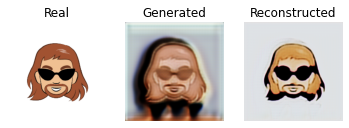

In [48]:
show_plot(A_real, B_generated, A_reconstructed)

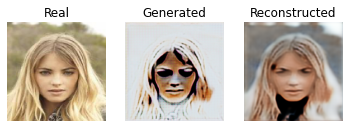

In [49]:
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

In [56]:
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = np.expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

In [58]:
# load the image
image_src = load_image('/content/drive/MyDrive/graduation_project/datasets/trainCartoon/cs100214067654451312.png')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/g_model_AtoB_002500.h5', cust)

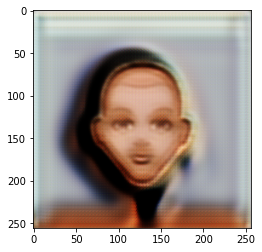

In [59]:
# translate image
image_tar = model_AtoB.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
# plot the translated image
pyplot.imshow(image_tar[0])
pyplot.show()